## Simple Harmonic Oscillator Physics Informed Neural Network
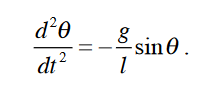

## Import Libraries

In [125]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


## Generate Training, Testing Data, and Parameters
Theres a lot of arbitrary data such as the length of the pendulum, and the initial angle. Though I assume this is arbitrary because I don't think it should affect the predicitions in the angle given the inputs.

In [126]:
# Parameters for the pendulum
L = 1.0  # Length of the pendulum (m)
g = 9.81  # Acceleration due to gravity (m/s^2)
theta_0 = np.pi / 4  # Initial angle (rad)
omega_0 = 0.0  # Initial angular velocity (rad/s)

# Time span for the simulation
t_start = 0.0
t_end = 10.0
num_points = 500
t = np.linspace(t_start, t_end, num_points)


def pendulum_solver(state, t, L, g):
    theta, theta_dot = state
    theta_ddot = - (g / L) * np.sin(theta)
    return [theta_dot, theta_ddot]

initial_state = [np.pi/4, 0]    
t = np.linspace(0, 10, 500)
x = torch.tensor(t, dtype=torch.float32).view(-1, 1).to(device)

states = odeint(pendulum_solver, initial_state, t, args=(L, g))
y = torch.tensor(states[:, 0], dtype=torch.float32).view(-1, 1).to(device)
print(x.shape, y.shape)

x_data = x[0:200:20].to(device)
y_data = y[0:200:20].to(device)
print(x_data.shape, y_data.shape)


torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


## Create Neural Network

In [127]:
class PINN(nn.Module):
    def __init__(self, layers):
        """
        Initialize the PINN model.
        
        Args:
            layers (list): List containing the number of neurons in each layer.
        """
        super().__init__()

        self.activation = nn.Tanh() #activation function
        self.loss_function = nn.MSELoss(reduction ='mean') #loss function

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        '''
        #  MANUAL LAYERS, 4 layers with 2 hidden
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        '''
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        """
        Forward pass through the PINN model.
        
        Args:
            x (tensor): Input tensor.
        
        Returns:
            tensor: Output tensor.
        """
        for layer in self.linears[:-1]:  # Exclude the last linear layer
            x = self.activation(layer(x))
        x = self.linears[-1](x)  # Apply the last linear layer without activation
        return x

    def loss(self, x_data, x_physics, theta_true, L, g):
        """
        Compute the loss function for the PINN model.
        
        Args:
            x_data (tensor): Input tensor for data points.
            x_physics (tensor): Input tensor for physics-informed points.
            theta_true (tensor): True theta values.
            L (float): Length of the pendulum.
            g (float): Acceleration due to gravity.
        
        Returns:
            tensor: Total loss.
        """
        yh = self(x_data)
        data_loss = torch.mean((yh-y_data)**2)

        theta_pred = self(x_physics)
        # automatic differentiation to find the first and second derivatives
        theta_pred_dot = torch.autograd.grad(theta_pred, x_physics, torch.ones_like(x_physics), create_graph=True)[0]
        theta_pred_ddot = torch.autograd.grad(theta_pred_dot, x_physics, torch.ones_like(x_physics), create_graph=True)[0]
        physics_residual = theta_pred_ddot + (g / L) * torch.sin(theta_pred) # ideally should be zero, difference between secondd derivative computed and gravitational force on pendulum by computed value
        physics_loss = torch.mean(physics_residual**2) # MSE error

        #data_loss = self.loss_function(theta_pred, theta_true)
        #physics_loss = self.loss_function(physics_residual, torch.zeros_like(physics_residual))
        return data_loss + physics_loss



## MAIN

Epoch 0, Loss: 1.9382200241088867
Epoch 1000, Loss: 0.24482694268226624
Epoch 2000, Loss: 0.19062396883964539
Epoch 3000, Loss: 0.16533899307250977
Epoch 4000, Loss: 0.14051468670368195
Epoch 5000, Loss: 0.13597016036510468
Epoch 6000, Loss: 0.12801730632781982
Epoch 7000, Loss: 0.11840617656707764
Epoch 8000, Loss: 0.10822588205337524
Epoch 9000, Loss: 0.09497134387493134


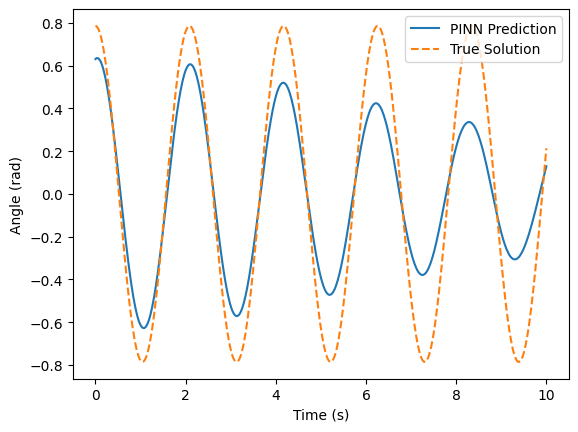

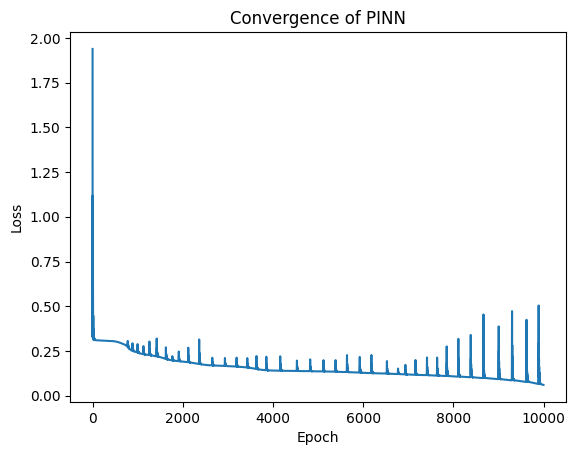

In [128]:
x_physics = torch.linspace(0,10,500).view(-1,1).requires_grad_(True).to(device)

# 8 hidden layers of 20 neurons, with 1 input and 1 output layer
layer_sizes = [1,20,20,20,20,20,20,20,20,1]

model = PINN(layer_sizes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = model(x_physics)
    loss = model.loss(x_data, x_physics, y_data, L, g)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Test the model
y_pred = model(x).cpu().detach().numpy()

#xp = x_physics.detach().numpy()

# Plot the results
plt.plot(x.cpu().detach().numpy(), y_pred, label='PINN Prediction')
plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy(), label='True Solution', linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()

# Plot the convergence graph
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convergence of PINN')
plt.show()